https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

I'll attempt to implement everything myself to get a better idea of how to do raptor, in case there's any edge cases i miss. Will reuse the docs they provide though.

Questions have different levels of abstractions. Hence, your documents can be fed in an LLM reccursive to build summarizations (which are higher level abstractions) a certain number of times. These LLM generated abstractions can then be saved as docs back into your vectorstore.

Document loading part has many broken links, update to use other pages

<function matplotlib.pyplot.show(close=None, block=None)>

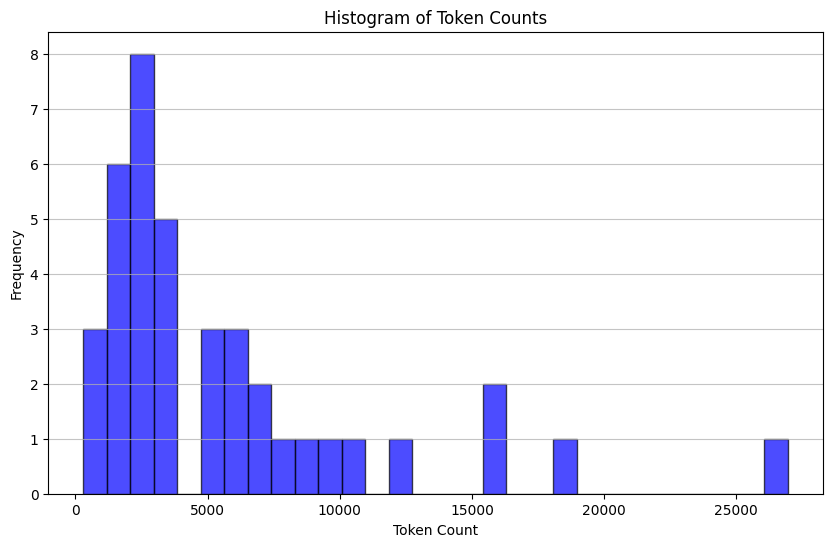

In [1]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
import re


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


doc_urls = [
    'https://scikit-learn.org/stable/modules/linear_model.html',
    'https://scikit-learn.org/stable/modules/lda_qda.html',
    'https://scikit-learn.org/stable/modules/kernel_ridge.html',
    'https://scikit-learn.org/stable/modules/svm.html',
    'https://scikit-learn.org/stable/modules/sgd.html',
    'https://scikit-learn.org/stable/modules/neighbors.html',
    'https://scikit-learn.org/stable/modules/gaussian_process.html',
    'https://scikit-learn.org/stable/modules/cross_decomposition.html',
    'https://scikit-learn.org/stable/modules/naive_bayes.html',
    'https://scikit-learn.org/stable/modules/tree.html',
    'https://scikit-learn.org/stable/modules/ensemble.html',
    'https://scikit-learn.org/stable/modules/multiclass.html',
    'https://scikit-learn.org/stable/modules/feature_selection.html',
    'https://scikit-learn.org/stable/modules/semi_supervised.html',
    'https://scikit-learn.org/stable/modules/isotonic.html',
    'https://scikit-learn.org/stable/modules/calibration.html',
    'https://scikit-learn.org/stable/modules/neural_networks_supervised.html',
    'https://scikit-learn.org/stable/modules/mixture.html',
    'https://scikit-learn.org/stable/modules/manifold.html',
    'https://scikit-learn.org/stable/modules/clustering.html',
    'https://scikit-learn.org/stable/modules/decomposition.html',
    'https://scikit-learn.org/stable/modules/covariance.html',
    'https://scikit-learn.org/stable/modules/outlier_detection.html',
    'https://scikit-learn.org/stable/modules/density.html',
    'https://scikit-learn.org/stable/modules/neural_networks_unsupervised.html',
    'https://scikit-learn.org/stable/modules/cross_validation.html',
    'https://scikit-learn.org/stable/modules/grid_search.html',
    'https://scikit-learn.org/stable/modules/classification_threshold.html',
    'https://scikit-learn.org/stable/modules/model_evaluation.html',
    'https://scikit-learn.org/stable/modules/learning_curve.html',
    'https://scikit-learn.org/stable/modules/partial_dependence.html',
    'https://scikit-learn.org/stable/modules/permutation_importance.html',
    'https://scikit-learn.org/stable/modules/compose.html',
    'https://scikit-learn.org/stable/modules/feature_extraction.html',
    'https://scikit-learn.org/stable/modules/preprocessing.html',
    'https://scikit-learn.org/stable/modules/impute.html',
    'https://scikit-learn.org/stable/modules/unsupervised_reduction.html',
    'https://scikit-learn.org/stable/modules/random_projection.html',
    'https://scikit-learn.org/stable/modules/kernel_approximation.html'
]

docs = []
for url in doc_urls:
    loader = RecursiveUrlLoader(
        url=url, max_depth=3, extractor=lambda x: Soup(x, "html.parser").text
    )
    docs.extend(loader.load())

def process_doc(doc):
    doc = doc.strip()
    preamble_match = re.search('^.+User Guide', doc, re.DOTALL)
    try:
        end_match = re.search('On this page.+$', doc, re.DOTALL)
        doc = doc[preamble_match.end():end_match.start()]
    except:
        doc = doc[preamble_match.end():]
    return doc.strip()

# Doc texts
docs_texts = [process_doc(d.page_content) for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [2]:
concatenated_content = "\n\n\n --- \n\n\n".join(docs_texts)

In [3]:
num_tokens_from_string(concatenated_content, "cl100k_base")

221859

In [10]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 400
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=100
)
texts_split = text_splitter.split_text(concatenated_content)
len(texts_split)

914

Raptor's paper suggests the following method of clustering:
1. Use UMAP to reduce dimensionality of embedding
2. Global cluster using Gaussian mixture model 
3. Local cluster using Gaussian mixture model

Try to do this dev urself

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from langchain_ollama import OllamaEmbeddings
from langchain_ollama.chat_models import ChatOllama
import numpy as np
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
import langchain 
langchain.debug = True 

In [12]:
def gmm_clustering(X, K, k, cv_fold=5):
    """Given a 2d array, where every row is 1 sample point, run GMM clustering on it repeatedly,
    searching for the best cluster size, based on BIC.
    params:
        X (2d array): size m x n, float.
        K (int): maximum cluster size to try
        k (int): minimum cluster size to try

    return:
        clusters (1d array): size m, containing the array of 0-k values, where k is the optimum cluster size.
    """
    def gmm_bic_score(estimator, X):
        """Callable to pass to GridSearchCV that will use the BIC score."""
        # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(X)
    
    max_cluster_trial = int(min(X.shape[0], K) * (1 - 1 / cv_fold))
    
    param_grid = {
        "n_components": range(k, max_cluster_trial),
        "covariance_type": ['full', 'tied', 'diag', 'spherical']
    }
    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, cv=cv_fold
    )
    grid_search.fit(X)
    print(f"Selected params for clustering: {grid_search.best_params_}, with BIC score: {grid_search.best_score_}")
    return grid_search.best_estimator_.predict(X)

In [20]:
def raptor(documents, summarization_chain, desired_embedding_size=128, global_max_clusters=5, local_max_clusters=45):
    # Does one loop of raptor, returns a list of dic, listing global cluster, local cluster, summary, documents for summary
    return_values = []
    documents_array = np.array(documents)
    # Get embeddings
    embed = OllamaEmbeddings(
        model="nomic-embed-text:v1.5"
    )
    full_embeddings = np.array(embed.embed_documents(documents))
    # This removes the need for UMAP
    compressed_embeddings = full_embeddings[:, :desired_embedding_size]

    # Get clusters
    global_clusters = gmm_clustering(compressed_embeddings, global_max_clusters, 2)
    # Iterate over each global cluster
    for global_cluster_index in set(global_clusters):
        # Select all documents/embeddings of this global cluster
        global_cluster_embeddings = compressed_embeddings[global_clusters==global_cluster_index]
        global_cluster_documents = documents_array[global_clusters==global_cluster_index]
        print(f"Global cluster: {global_cluster_index}, has {len(global_cluster_documents)} documents.")
        # recluster into local cluster
        local_clusters = gmm_clustering(global_cluster_embeddings, local_max_clusters, 3, cv_fold=3)
        for local_cluster_index in set(local_clusters):
            # Select all documents of this local cluster
            local_cluster_documents = global_cluster_documents[local_clusters==local_cluster_index]
            print(f"Global cluster: {global_cluster_index}, Local cluster: {local_cluster_index}, has {len(local_cluster_documents)} documents.")
            # Hit LLM for summarization
            summarization = summarization_chain.invoke(local_cluster_documents)
            return_values.append({
                'global_cluster': global_cluster_index,
                'local_cluster': local_cluster_index,
                'summarization': summarization,
                'clustered_documents': local_cluster_documents.tolist()
            })
    return return_values



In [21]:
llm = ChatOllama(model="llama3.2:3b-instruct-q8_0", temperature=0)

summarization_prompt_template = """Your job is to give a detailed summary of the following documents:

Documents:
{documents}
"""

summarization_prompt = ChatPromptTemplate.from_template(summarization_prompt_template)

summarization_chain = (
    RunnableLambda(lambda docs: '\n---------new doc---------\n'.join(docs))
    | summarization_prompt
    | llm
    | StrOutputParser()
)

In [22]:
leaf_1 = raptor(texts_split, summarization_chain, desired_embedding_size=256)

Selected params for clustering: {'covariance_type': 'spherical', 'n_components': 2}, with BIC score: 212464.15781760923
Global cluster: 0, has 449 documents.
Selected params for clustering: {'covariance_type': 'spherical', 'n_components': 3}, with BIC score: 170945.4248511313
Global cluster: 0, Local cluster: 0, has 176 documents.
[chain/start] [chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > chain:RunnableLambda] Entering Chain run with input:
[inputs]
[chain/end] [chain:RunnableSequence > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "The coefficient estimates for Ordinary Least Squares rely on the\nindependence of the features. When features are correlated and the\ncolumns of the design matrix \\(X\\) have an approximately linear\ndependence, the design matrix becomes close to singular\nand as a result, the least-squares estimate becomes highly sensitive\nto random errors in the observed target, producin

KeyboardInterrupt: 

In [16]:
130445 / 4

32611.25